## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
#1
url = "https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt?dl=1"

print("Retrieving data from",url)
data=pd.read_csv(url,delimiter=",") #così carico tutto il file e basta, ovviamente N sarà minore o uguale del massimo possibile e maggiore di 10000
print("data.shape:",data.shape)
print("Displaying retrieved data")
display(data)

Retrieving data from https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt?dl=1
data.shape: (1310720, 6)
Displaying retrieved data


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


In [4]:
#2

#dopo averci pensato a lungo non penso che esista un modo "deterministico" per trovare x, ma solo "probabilistico". In particolare avendo moltissimi dati è molto probabile che almeno una volta ci sia stato un evento l'istante prima dello "scattare dell'ora", e che quindi il massimo BX presente nei dati sia x-1 analogamente a come in un orologio normale non si può mai osservare per i minuti un valore maggiore di 59. Chiaramente così si può a rigore solo stimare un limite inferiore per x (se ad esempio gli eventi fossero dotati di una periodicità "brutta" magari avverrebbero tutti subito dopo lo scattare dell'orbit rendendoci impossibile trovare x), ma su tanti dati relativi a eventi casuali otteniamo in realtà x stesso.

x = data["BX_COUNTER"].values.max()+1
print(x)

3564


In [5]:
#3

#tempo di acquisizione = istante finale - istante iniziale (nelle stesse unità di misura)
Y = 25 #ns in 1 bx
Z = 25/30 #ns in 1 tdc
X = x*Y
t = data.shape[0]-1
T = data["ORBIT_CNT"].values[t]*X+data["BX_COUNTER"].values[t]*Y+data["TDC_MEAS"].values[t]*Z-data["ORBIT_CNT"].values[0]*X+data["BX_COUNTER"].values[0]*Y+data["TDC_MEAS"].values[0]*Z
T *= 1e-9
print("total acquisition time in seconds:",T)

total acquisition time in seconds: 0.9805348366666667


In [6]:
#4

time = data["ORBIT_CNT"]*X+data["BX_COUNTER"]*Y+data["TDC_MEAS"]*Z

data_with_abs_time = data.copy().assign(ABS_TIME_NS=time) #https://www.geeksforgeeks.org/adding-new-column-to-existing-dataframe-in-pandas/ esistono svariate alternative
display(data_with_abs_time) #assign modifica il dataframe iniziale

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME_NS
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,3.447467e+14
1310716,1,1,4,3869211171,763,11,3.447467e+14
1310717,1,0,64,3869211171,764,0,3.447467e+14
1310718,1,0,139,3869211171,769,0,3.447467e+14


In [7]:
#5

data["HEAD"] = np.random.randint(2,size=data.shape[0])
display(data)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,0,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,0,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,0,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


In [8]:
#6

data_head_1 = data[data["HEAD"] == 1]
display(data_head_1)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
5,1,0,63,3869200167,2762,4
8,1,0,62,3869200167,2774,21
...,...,...,...,...,...,...
1310714,1,0,60,3869211171,762,2
1310715,1,0,62,3869211171,762,14
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


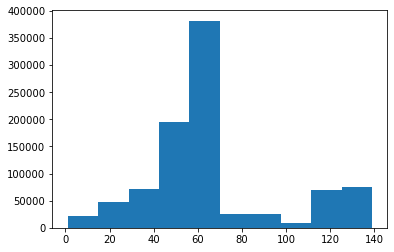

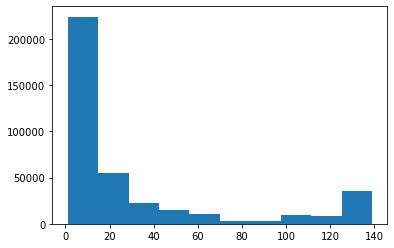

In [12]:
#7
d=dict()
for n in data["FPGA"] :
    d[n]=d.get(n,0)+1

#print(d)
#ci sono solo 2 FPGA
fpga1 = data["FPGA"] == 0
fpga2 = data["FPGA"] == 1
plt.hist(data[fpga1]["TDC_CHANNEL"]);
plt.figure();
plt.hist(data[fpga2]["TDC_CHANNEL"]);


In [29]:
#8

data_grouped = data.groupby("TDC_CHANNEL").count()
#display(data_grouped)
data_grouped = data_grouped.sort_values(by="HEAD",ascending=False) #l'una colonna vale l'altra
#display(data_grouped)
print(data_grouped.index[0:3])

Int64Index([139, 64, 63], dtype='int64', name='TDC_CHANNEL')


In [19]:
#9
d=dict()
for n in data["ORBIT_CNT"] :
    d[n]=d.get(n,0)+1
print("number of unique orbits:",len(d.keys()))

#adesso faccio lo stesso ma isolando le righe con TDC_CHANNEL=139; così mi garantisco di contare solo le orbit che almeno una volta hanno soddisfatto questa condizione - e quindi sono sopravvissute al logical masking. 

d=dict()
for n in data[data["TDC_CHANNEL"]==139]["ORBIT_CNT"] :
    d[n]=d.get(n,0)+1
print("number of unique orbits with at least one measurement with TDC_CHANNEL=139:",len(d.keys()))

number of unique orbits: 11001
number of unique orbits with at least one measurement with TDC_CHANNEL=139: 10976
